In [9]:
import os
import json

# external library
import cv2
import numpy as np
from tqdm.auto import tqdm
import albumentations as A
import matplotlib.pyplot as plt

# torch
import torch
from torch.utils.data import Dataset

In [10]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "/Users/johyewon/Desktop/BoostCamp/Project/4. Semnatic-Segmentation/Code/data/train/DCM"
LABEL_ROOT = "/Users/johyewon/Desktop/BoostCamp/Project/4. Semnatic-Segmentation/Code/data/train/outputs_json"

In [11]:
# 데이터셋 생성
def create_dataset(image_root, label_root):
    pngs = [
        os.path.relpath(os.path.join(root, fname), start=image_root)
        for root, _dirs, files in os.walk(image_root)
        for fname in files
        if os.path.splitext(fname)[1].lower() == ".png"
    ]
    jsons = [
        os.path.relpath(os.path.join(root, fname), start=label_root)
        for root, _dirs, files in os.walk(label_root)
        for fname in files
        if os.path.splitext(fname)[1].lower() == ".json"
    ]

    # 이미지 이름과 레이블 이름이 일치하는지 확인
    jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
    pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

    assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
    assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

    # 이름을 정렬하고 numpy 배열로 변환
    pngs = sorted(pngs)
    jsons = sorted(jsons)
    pngs = np.array(pngs)
    jsons = np.array(jsons)

    return pngs, jsons

In [81]:
# 데이터셋 생성
pngs, jsons = create_dataset(IMAGE_ROOT, LABEL_ROOT)

# pngs와 jsons를 리스트로 변환합니다.
pngs = list(pngs)
jsons = list(jsons)

In [82]:
# 클래스 정보 (JSON 파일에서 라벨 정보를 가져옵니다)
CLASSES = []
for label_name in jsons:
    with open(os.path.join(LABEL_ROOT, label_name), "r") as f:
        annotations = json.load(f)
    for ann in annotations["annotations"]:
        label = ann["label"]
        if label not in CLASSES:
            CLASSES.append(label)

# 클래스를 인덱스에 매핑
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [108]:
class XRayDataset(Dataset):
    def __init__(self, filenames, labelnames, transforms=None, is_train=False):
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
        self.CLASSES = CLASSES
        self.CLASS2IND = CLASS2IND 

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
    
        try:
            image = cv2.imread(image_path)
            image = image / 255.  # 이미지 정규화
    
            label_shape = tuple(image.shape[:2]) + (len(self.CLASSES), )
            label = np.zeros(label_shape, dtype=np.uint8)

            # 레이블 이름을 가져옵니다.
            label_name = self.labelnames[item]
            # 레이블 경로를 생성합니다.
            label_path = os.path.join(LABEL_ROOT, label_name)
            
            with open(label_path, "r") as f:
                annotations = json.load(f)

            for ann in annotations["annotations"]:
                c = ann["label"]
                points = np.array(ann["points"])
                class_label = np.zeros(image.shape[:2], dtype=np.uint8)
                cv2.fillPoly(class_label, [points], 1)
                label[..., self.CLASS2IND[c]] = np.maximum(label[..., self.CLASS2IND[c]], class_label)

            if self.transforms is not None:
                inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
                result = self.transforms(**inputs)
    
                image = result["image"]
                label = result["mask"] if self.is_train else label
    
            # 이미지와 레이블을 채널 우선 형태로 변환
            image = image.transpose(2, 0, 1)  
            label = label.transpose(2, 0, 1)
    
            image = torch.from_numpy(image).float()
            label = torch.from_numpy(label).float()
    
            return image, label
    
        except Exception as e:
            print(f"Error: {e}")
            return None, None

In [109]:
# 색상 정의
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

In [110]:
def label2rgb(label):
    # 이미지 크기 설정: (H, W, 3) 형태로 이미지 생성
    image_size = label.shape[:2] + (3,)
    image = np.zeros(image_size, dtype=np.uint8)

    # 각 클래스를 순차적으로 처리하면서 이미지에 색을 적용
    for i in range(label.shape[2]):  # label.shape[2] = 29, 클래스 수만큼 반복
        image[label[:, :, i] == 1] = PALETTE[i]  # 해당 클래스에 맞는 PALETTE 색 적용

    return image

In [126]:
# 이미지 위에 라벨 생성

def visualize_images_and_labels(image, label):
    if image is None or label is None:
        print("Error: Image or label is None. Cannot visualize.")
        return

    # 이미지와 레이블을 NumPy 배열로 변환
    image = image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    label = label.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

    # 레이블을 RGB 이미지로 변환
    label_overlay = label2rgb(label)

    # 이미지를 uint8 타입으로 변환
    image = (image * 255).astype(np.uint8) 

    # 이미지와 레이블을 겹쳐서 시각화
    alpha = 0.5  # 레이블 오버레이의 투명도 (0.0 ~ 1.0)
    output_image = cv2.addWeighted(image, 1, label_overlay, alpha, 0)

    # 마스크 위에 클래스 이름을 표시합니다.
    for i in range(label.shape[2]):
        if np.any(label[:, :, i]):  # 해당 클래스의 마스크가 존재하는 경우
            class_name = IND2CLASS[i]
            # 마스크 영역의 중심 좌표를 계산합니다.
            contours, _ = cv2.findContours(label[:, :, i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                M = cv2.moments(contours[0])
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])

                # 텍스트를 마스크 위에 표시합니다.
                cv2.putText(output_image, class_name, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0, 1), 1) 

    # Matplotlib을 사용하여 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(output_image)
    plt.title("Image with Segmentation Mask")
    plt.axis('off')  # 축 제거
    plt.show()

In [127]:
# 랜덤으로 1개 ID를 선택 (1 ~ 548)
id_num = np.random.randint(1, 549)
id_folder = f"ID{id_num:03d}"

print(f"ID: {id_folder}")


ID: ID427


In [128]:
# 왼손/오른손 이미지 파일 선택
left_filenames = [filename for filename in pngs if f"{id_folder}/image" in filename and filename.endswith("_L.png")]
right_filenames = [filename for filename in pngs if f"{id_folder}/image" in filename and filename.endswith("_R.png")]

left_labelnames = [label for label in jsons if f"{id_folder}/image" in label and label.endswith("_L.json")]
right_labelnames = [label for label in jsons if f"{id_folder}/image" in label and label.endswith("_R.json")]

print(f"Left: {left_filenames}, Right: {right_filenames}")
print(f"Left: {left_labelnames}, Right: {right_labelnames}")


Left: ['ID427/image1666059630733_L.png'], Right: ['ID427/image1666059605746_R.png']
Left: ['ID427/image1666059630733_L.json'], Right: ['ID427/image1666059605746_R.json']


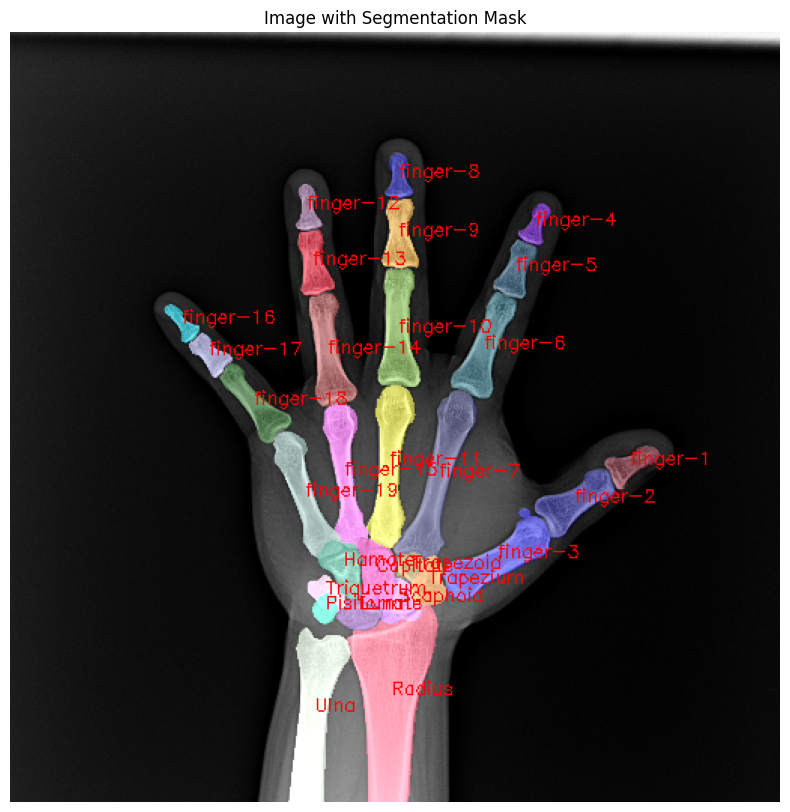

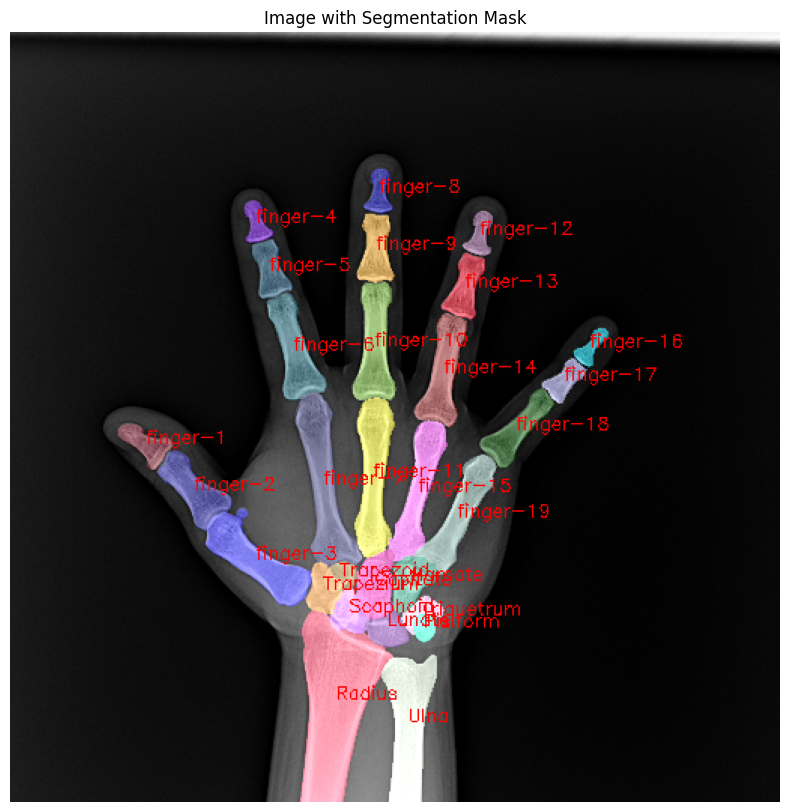

In [129]:
# 데이터셋 생성
transform = A.Resize(512, 512)
left_dataset = XRayDataset(left_filenames, left_labelnames, transforms=transform, is_train=True)
right_dataset = XRayDataset(right_filenames, right_labelnames, transforms=transform, is_train=True)

# 왼손/오른손 이미지 시각화
left_image, left_label = left_dataset[0]
right_image, right_label = right_dataset[0]
visualize_images_and_labels(left_image, left_label)
visualize_images_and_labels(right_image, right_label)